# June, 21st, 2021

**Motivation**: New Clusters object, better HTML display.  Visualize the amount of overlap between clusters and brain regions.
</br>

In [1]:
# HIDE CODE


import os
import sys
import ants
import nrrd
import collections
import numpy as np
import pandas as pd
import nibabel as nib
import networkx as nx
import operator as op
from time import time
from rich import print
from pathlib import Path
from pprint import pprint
from tqdm.notebook import tqdm
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')

# GitHub
sys.path.insert(0, pjoin(git_dir, 'Ca-fMRI'))
from analysis.cluster import Clusters
from analysis.hierarchical import *
from analysis.network import *
from utils.plotting import *
from utils.render import *
from utils.registration import *
from model.mouse import Mice

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def plot_parcellation(
    parcellation: np.ndarray,
    mask_l: np.ndarray,
    mask_r: np.ndarray,
    root_mask: np.ndarray,
    figsize=(6, 4),
    cmap='turbo', ):

    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    for i in range(2):
        for j in range(3):
            x = parcellation.copy()

            if i == 0:
                x[mask_r] = 0
                label = 'left\n'
            else:
                x[mask_l] = 0
                # x[x != 0] -= int(np.max(parcellation) // 2)
                label = 'right\n'

            if j == 0:
                title = 'coronal'
            elif j == 1:
                title = 'axial'
            else:
                title = 'saggital'

            data2plt = np.ma.masked_where(~root_mask.astype(bool), x)
            axes[i, j].imshow(data2plt.mean(j), cmap=cmap)

            list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if i == 0:
                axes[i, j].set_title(title, fontsize=17, y=1.2)
            else:
                axes[i, j].set_title('')
            if j == 0:
                axes[i, j].set_ylabel(label, fontsize=17)

    fig.tight_layout()
    plt.show()
    
    return fig, axes


def plot_registration(
    fixed: np.ndarray,
    moving: np.ndarray,
    warped: np.ndarray,
    figsize=(6, 8), ):
    
    sns.set_style('white')
    fig, axes = plt.subplots(3, 3, figsize=figsize)

    for i in range(3):
        for j in range(3):       
            if i == 0:
                x = fixed.numpy()
                label = 'fixed'
            elif i == 1:
                x = moving.numpy()
                label = 'moving'
            else:
                x = warped.numpy()
                label = 'warped'

            if i == 0:
                if j == 0:
                    top_title = 'axis = {:d}\n(coronal)'.format(j)
                elif j == 1:
                    top_title = 'axis = {:d}\n(axial)'.format(j)
                else:
                    top_title = 'axis = {:d}\n(saggital)'.format(j)
                axes[i, j].set_title(top_title, y=1.1, fontsize=13)

            if j == 0:
                axes[i, j].set_ylabel(label + '\n', fontsize=13)

            data2plt = x.mean(j)
            axes[i, j].imshow(data2plt)

            _ = list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    msg = 'Plotting averaged data across different dimensions\n\n'
    msg += '1st row (fixed):  Average template,    shape = {}\n'.format(fixed.shape)
    msg += '2nd row (moving):  Anatomical data,    shape = {}\n'.format(moving.shape)
    msg += '3rd row (warped):  Anatomical data,    shape = {}'.format(warped.shape)
    plt.suptitle(msg, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    return fig, axes


def viz_parcel(parcellation, figsize=(10, 4), bins=80):
    accepted, rejected = [], []
    all_distances_accepted = []
    for i, ctr in parcellation['cluster_centers'].items():
        num_voxels = (parcellation['parcel'] == i).sum()
        num_accepted = (parcellation['eroded'] == i).sum()    

        accepted.append(num_accepted) 
        rejected.append(num_voxels - num_accepted)

        points = np.array(tuple(zip(*np.where(parcellation['eroded'] == i))))
        d = sp_dist.cdist(ctr.reshape(-1, 3), points.reshape(-1, 3)).flatten()
        all_distances_accepted.extend(list(d))


    fig, axes = create_figure(1, 2, figsize, style='whitegrid')

    sns.histplot(rejected, color='C7', label='rejected', alpha=0.3, ax=axes[0])
    sns.histplot(accepted, color='C2', label='accepted', alpha=0.7, ax=axes[0])
    _min = np.min(accepted)
    _median = np.median(accepted)
    _max = np.max(accepted)
    axes[0].axvline(_min, color='C4', ls='--', lw=1.3, label=f"min: {_min}")
    axes[0].axvline(_median, color='C3', ls='--', lw=1.5, label=f"median: {_median}")
    axes[0].axvline(_max, color='C4', ls='--', lw=1.3, label=f"max: {_max}")
    axes[0].set_title('distribution of ROI sizes', fontsize=15, y=1.03)
    axes[0].set_xlabel('num voxels', fontsize=14)
    axes[0].legend()

    y, bin_edges = np.histogram(all_distances_accepted, bins=bins)
    x = (bin_edges[1:] + bin_edges[:-1]) / 2
    m, b = np.polyfit(x[y > 0], np.log2(y[y > 0]), 1)
    
    sns.histplot(
        all_distances_accepted, color='C6', stat='count',
        kde=True, line_kws={'lw': 4, 'label': f"fitted slope (log2): {np.round(m, 2)}"}, ax=axes[1]
    )
    axes[1].axvline(
        parcellation['radius'], color='k',
        label=f"max radius: {np.round(parcellation['radius'], 2)}",
        ls='--', lw=2
    )
    axes[1].set_xscale('log', base=2)
    axes[1].set_yscale('log', base=2)
    axes[1].set_title('voxel distances from ROI ctrs (eroded)', fontsize=15, y=1.03)
    axes[1].set_xlabel('r', fontsize=14)
    axes[1].legend(fontsize=13)

    fig.tight_layout()
    plt.show()

## Allen & Atlas

In [3]:
mice = Mice()
allen = load_allen()
atlas = fix_br_atlas()
atlas.space

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


<BGSpace AnatomicalSpace object>
origin: ('Anterior', 'Superior', 'Left')
sections: ('Frontal plane', 'Horizontal plane', 'Sagittal plane')
shape: (132, 80, 114)

## Tree graph (nx)

### Root

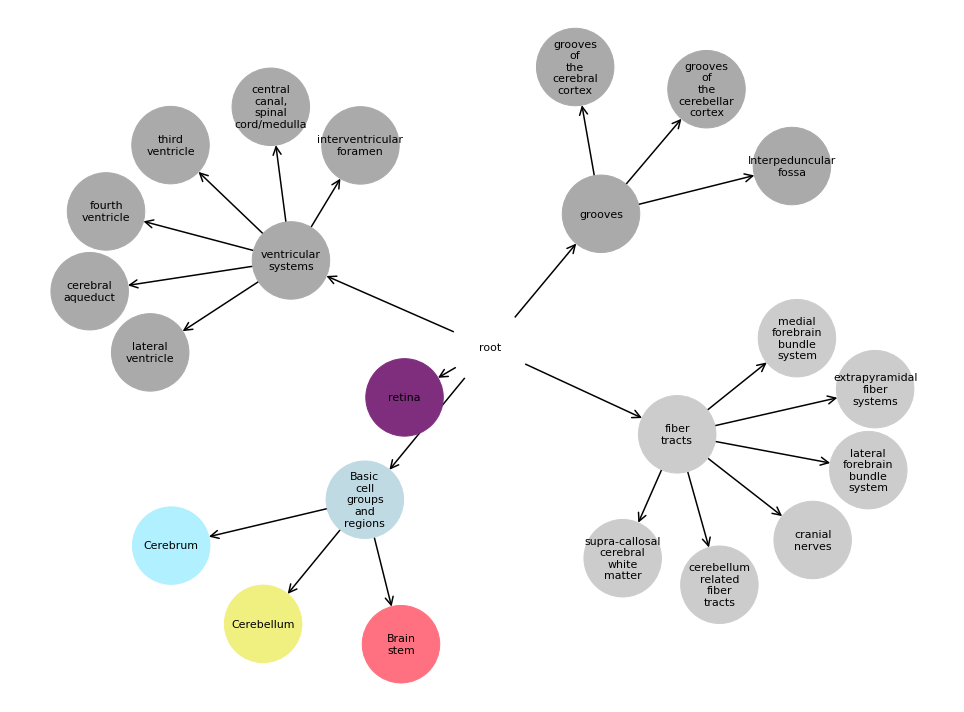

In [18]:
n_levels = 3
root = 'root'
tree = make_tree_graph(root, allen['mcc'], n_levels, use_acroym=False)

fig, ax = plot_nx_tree(tree, 'neato', node_size=6000)
fig_dir = pjoin(tmp_dir, f"{root}_{n_levels}lvls.pdf")
fig.savefig(fig_dir, bbox_inches='tight')

### Cerebrum

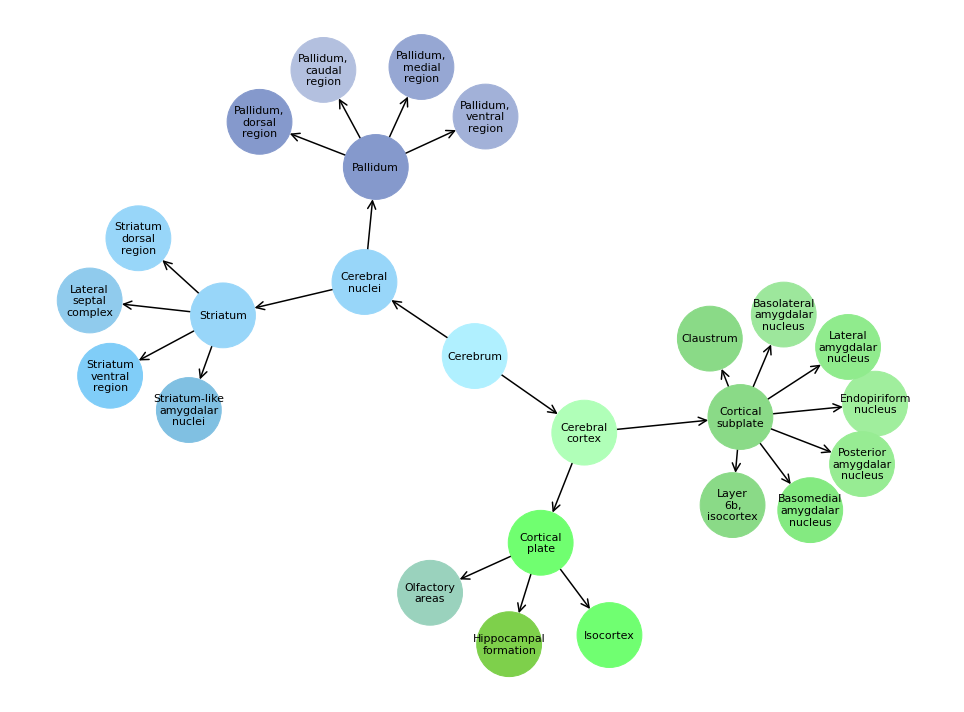

In [19]:
n_levels = 4
root = 'Cerebrum'
tree = make_tree_graph(root, allen['mcc'], n_levels, use_acroym=False)

fig, ax = plot_nx_tree(tree, 'neato')
fig_dir = pjoin(tmp_dir, f"{root}_{n_levels}lvls.pdf")
fig.savefig(fig_dir, bbox_inches='tight')

### Isocortex

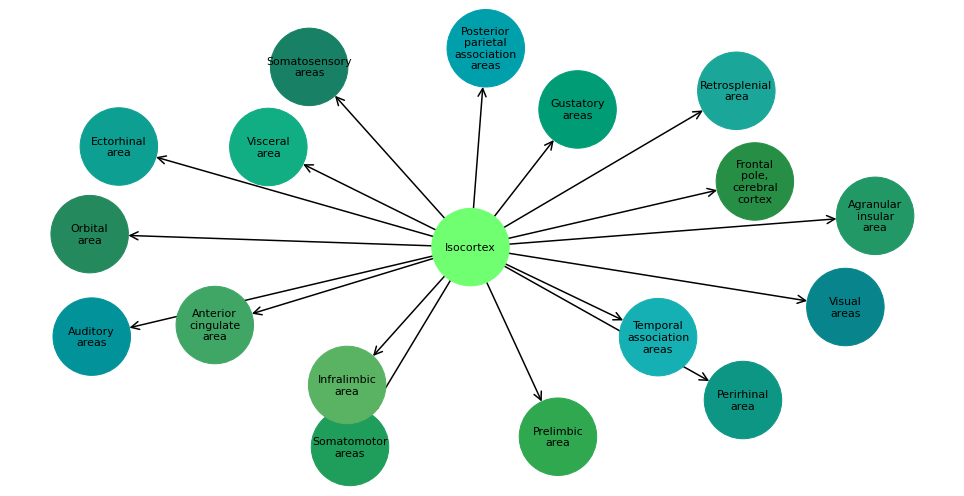

In [28]:
n_levels = 2
root = 'Isocortex'
tree = make_tree_graph(root, allen['mcc'], n_levels, use_acroym=False)

fig, ax = plot_nx_tree(tree, 'neato', figsize=(13.5, 7), arrowsize=20, node_size=6000)
fig_dir = pjoin(tmp_dir, f"{root}-neato_{n_levels}lvls.pdf")
fig.savefig(fig_dir, bbox_inches='tight')

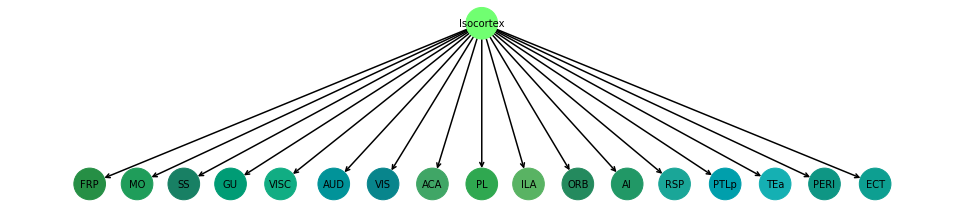

In [29]:
n_levels = 2
root = 'Isocortex'
tree = make_tree_graph(root, allen['mcc'], n_levels, use_acroym=True)

fig, ax = plot_nx_tree(tree, 'dot', figsize=(13.5, 3), arrowsize=10, node_size=1000)
fig_dir = pjoin(tmp_dir, f"{root}_{n_levels}lvls.pdf")
fig.savefig(fig_dir, bbox_inches='tight')

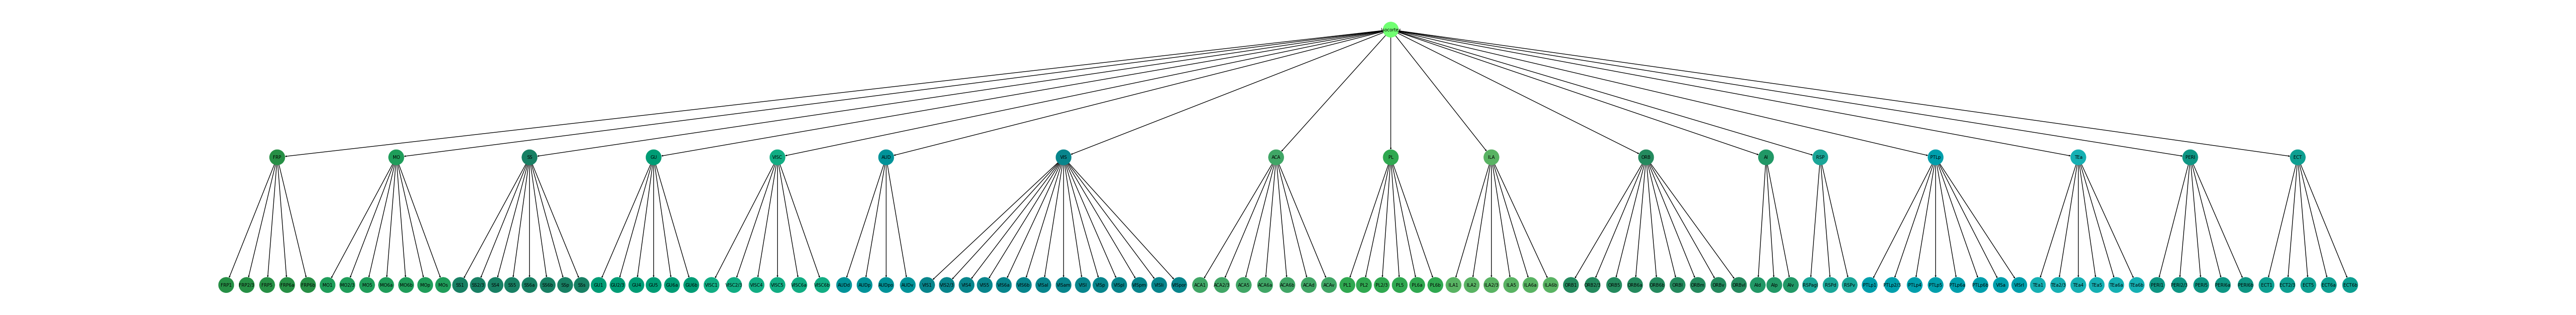

In [30]:
n_levels = 3
root = 'Isocortex'
tree = make_tree_graph(root, allen['mcc'], n_levels, use_acroym=True)

fig, ax = plot_nx_tree(tree, 'dot')
fig_dir = pjoin(tmp_dir, f"{root}_{n_levels}lvls.pdf")
fig.savefig(fig_dir, bbox_inches='tight')

## Compute ROIs

In [4]:
n_hemisphere_regions = 64

parcellation = kmeans_parcellation(
    mask=allen['isocortex_mask'],
    n_hemisphere_regions=n_hemisphere_regions,
    symmetrize=False,
    left_right_axis=2,
    random_state=42,
)
parcellation.keys()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


dict_keys(['parcel', 'eroded', 'eroded_masks', 'cluster_centers', 'mask_l', 'mask_r', 'n_cortical_regions', 'radius'])

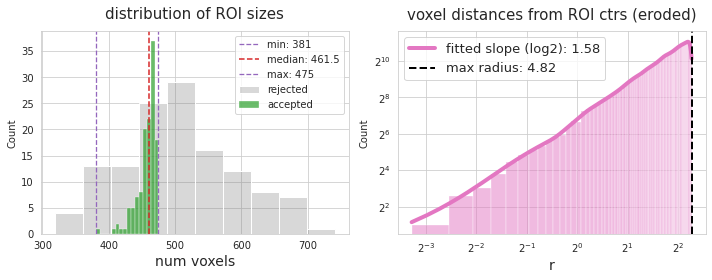

In [5]:
viz_parcel(parcellation)

### Render

#### Custom colormap

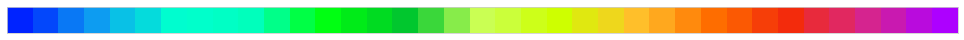

In [10]:
ramp_colors = [
    '#0023ff', '#0ea4f1', '#00ffcf', '#00ffc1',
    '#00ff0d', '#00c72e', '#caff58',
    '#cfff00', '#ffc22c', '#ff7200',
    '#f42c0b', '#d82789', '#ad00ff',
]
custom_cmap = make_cmap(
    ramp_colors=ramp_colors,
    n_colors=parcellation['n_cortical_regions'],
    name='custom',
)

#### Save HTML

In [11]:
_ = parcel2html(
    masks=parcellation['eroded_masks'],
    save_dir=extras_dir,
    cmap=custom_cmap,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/parcel-128_cmap-custom.html

### ROI mask

In [6]:
roi_masks, major_masks = get_roi_masks(parcellation, allen)

id: 477,	name: Striatum
id: 803,	name: Pallidum
id: 698,	name: Olfactory areas
id: 703,	name: Cortical subplate
id: 1089,	name: Hippocampal formation
id: 315,	name: Isocortex


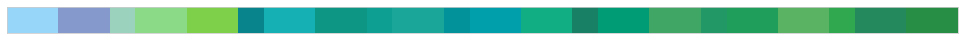

In [7]:
struct_colors = {
    acro: rgb2hex([
        item / 255 for item in
        allen['structure_tree'].get_structures_by_acronym([acro])[0]['rgb_triplet']
    ]) for acro in major_masks
}
struct_cmap = make_cmap(
    ramp_colors=list(struct_colors.values()),
    n_colors=len(struct_colors),
    name='structs',
)

In [14]:
_ = parcel2html(
    masks=major_masks,
    save_dir=extras_dir,
    cmap=struct_cmap,
    alpha_base=0.0,
    alpha_root=0.1,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/parcel-22_cmap-structs.html

### Overlap with fiber or ventricular?

In [15]:
names = [
    'fiber tracts',
    'ventricular systems',
    # 'grooves',
    # 'retina',
]
names

['fiber tracts', 'ventricular systems']

In [16]:
for name, struct in zip(names, allen['structure_tree'].get_structures_by_name(names)):
    try:
        _m = allen['mcc'].get_structure_mask(struct['id'])[0]
    except:
        print('Error: ', name)
        continue
    for k, m in roi_masks.items():
        num_overlap = np.logical_and(m, _m).sum()
        
        if num_overlap:
            fig, axes = create_figure(1, 2, figsize=(8, 6)) 
            axes[0].imshow(m.mean(0))
            axes[0].set_title(k)

            axes[1].imshow(_m.mean(0))
            axes[1].set_title(name)

            fig.suptitle(f"num overlap = {num_overlap}")
            fig.tight_layout()

            plt.show()

### Viz eroded

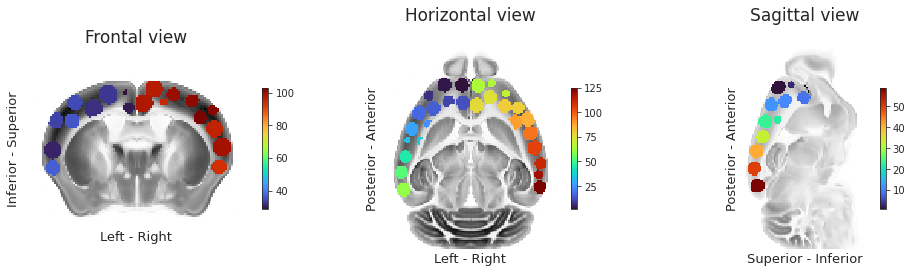

In [17]:
fig, axes = create_figure(1, 3, figsize=(13, 3.9))

slice_idxs = [58, 30, 44]
for i, (ax, plane, labels) in enumerate(zip(axes, atlas.space.sections, atlas.space.axis_labels)):
    data2plt = parcellation['eroded'].take(slice_idxs[i], axis=i)
    data2plt = np.ma.masked_where(data2plt == 0, data2plt)
    ax.imshow(atlas.reference.take(slice_idxs[i], axis=i), cmap='Greys')
    im = ax.imshow(data2plt, cmap='turbo')
    plt.colorbar(im, ax=ax, shrink=0.6)
    
    ax.set_title(f"{plane.capitalize()} view\n", fontsize=17)
    ax.set_ylabel(labels[0], fontsize=13)
    ax.set_xlabel(labels[1], fontsize=13)

    _ = list(map(lambda x: x.set_visible(False), ax.spines.values()))
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

## Load func data

In [8]:
df = pd.read_pickle(pjoin(tmp_dir, 'func_data.df'))

df_table = {}
for key, (subject, session, run) in mice.looper.items():
    selected_df = df.loc[
        (df.subject == subject) &
        (df.session == session) &
        (df.run == run)
    ]
    if len(selected_df):
        df_table[key] = selected_df.pivot(index='timepoint', columns='region_id', values='bold')
        
df_combined = pd.concat(df_table.values())
node_labels = df_combined.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.shape, df_combined.shape

((3187800, 7), (23100, 138))

## Hierarchical clustering

In [9]:
hier_results = hierarchical_cluster(
    df=df_combined,
    method='ward',
    dist_metric='canberra',
    link_metric='canberra',
)
labels = translate_labels(hier_results['labels'], allen['mcc'])

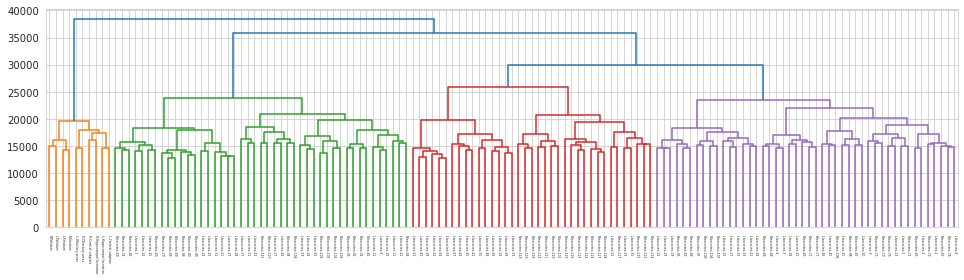

In [10]:
hier_output = get_clust_graph(
    linkage_mat=hier_results['z'],
    labels=labels,
    num_clusters=0,
    leaf_font_size=3,
    orientation='top',
    figsize=(13.5, 4),
)
display(hier_output['fig'])

### All clusters

In [11]:
cluster_color_idxs = {
    2: [0, 16],
    3: [0, 4, 12], 
    4: [0, 8, 4, 12],
    5: [0, 8, 4, 6, 12],
    6: [0, 8, 10, 4, 6, 12],
    7: [0, 8, 10, 4, 6, 12, 14],
    8: [0, 8, 10, 4, 6, 12, 14, 15],
    9: [0, 8, 10, 11, 4, 6, 12, 14, 15],
    10: [0, 8, 10, 11, 4, 6, 7, 12, 14, 15],
    11: [0, 8, 10, 11, 4, 6, 7, 12, 13, 14, 15],
    12: [0, 8, 9, 10, 4, 5, 6, 7, 12, 13, 14, 15],
    13: [0, 8, 9, 10, 11, 4, 5, 6, 7, 12, 13, 14, 15],
    14: [0, 2, 8, 9, 10, 11, 4, 5, 6, 7, 12, 13, 14, 15],
}
struct_colors = {
    acro: rgb2hex([
        item / 255 for item in
        allen['structure_tree'].get_structures_by_acronym([acro])[0]['rgb_triplet']
    ]) for acro in major_masks
}

n_clusters = 2

#1f77b4,"['(10)', '(128)']"


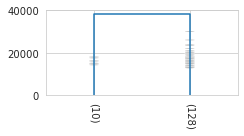

n_clusters = 3

#1f77b4,"['(10)', '(45)', '(83)']"


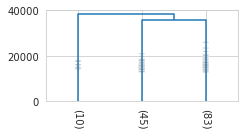

n_clusters = 4

#1f77b4,"['(10)', '(45)', '(37)', '(46)']"


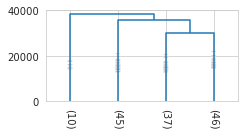

n_clusters = 5

#1f77b4,"['(10)', '(45)', '(46)']"
#ff7f0e,"['(16)', '(21)']"


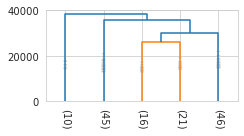

n_clusters = 6

#1f77b4,"['(10)', '(46)']"
#ff7f0e,"['(19)', '(26)']"
#2ca02c,"['(16)', '(21)']"


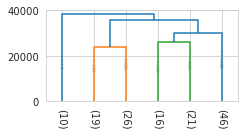

n_clusters = 7

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(26)']"
#2ca02c,"['(16)', '(21)']"
#d62728,"['(16)', '(30)']"


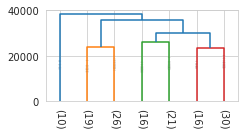

C_1 STR 100% PAL 100% OLF 100% CTXsp 100% HPF 100% C_2 PERI 93% ECT 92% VISC 86% TEa 51% GU 36% AI 30% MO 27% SS 26% AUD 7% FRP 3% PL 2% ACA 1% ORB 1% C_3 GU 39% SS 34% MO 24% VISC 13% AI 4% C_4 VIS 48% AUD 47% PTLp 41% TEa 26% SS 9% RSP 8% ECT 2% PERI 1% VISC 1% C_5 RSP 57% VIS 51% AUD 46% TEa 23% PTLp 23% SS 10% PERI 6% ECT 6% C_6 PTLp 36% MO 25% SS 21% ACA 10% RSP 8% VIS 1% C_7 ILA 100% ORB 99% PL 98% FRP 97% ACA 89% AI 66% RSP 27% GU 25% MO 25%

STR C_1 100% PAL C_1 100% OLF C_1 100% CTXsp C_1 100% HPF C_1 100% VIS C_5 51% C_4 48% C_6 1% TEa C_2 51% C_4 26% C_5 23% PERI C_2 93% C_5 6% C_4 1% ECT C_2 92% C_5 6% C_4 2% RSP C_5 57% C_7 27% C_4 8% C_6 8% AUD C_4 47% C_5 46% C_2 7% PTLp C_4 41% C_6 36% C_5 23% VISC C_2 86% C_3 13% C_4 1% SS C_3 34% C_2 26% C_6 21% C_5 10% C_4 9% GU C_3 39% C_2 36% C_7 25% ACA C_7 89% C_6 10% C_2 1% AI C_7 66% C_2 30% C_3 4% MO C_2 27% C_7 25% C_6 25% C_3 24% ILA C_7 100% PL C_7 98% C_2 2% ORB C_7 99% C_2 1% FRP C_7 97% C_2 3%

n_clusters = 8

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(26)']"
#2ca02c,"['(16)', '(21)']"
#d62728,"['(16)', '(9)', '(21)']"


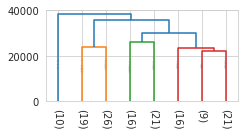

n_clusters = 9

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(9)', '(17)']"
#2ca02c,"['(16)', '(21)']"
#d62728,"['(21)', '(16)', '(9)']"


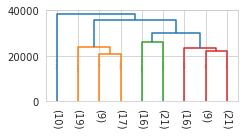

n_clusters = 10

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(9)', '(17)']"
#2ca02c,"['(16)', '(7)', '(14)']"
#d62728,"['(9)', '(21)', '(16)']"


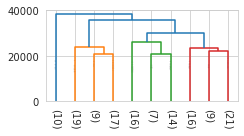

n_clusters = 11

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(9)', '(17)']"
#2ca02c,"['(16)', '(7)', '(14)']"
#d62728,"['(9)', '(7)', '(14)', '(16)']"


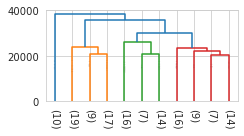

n_clusters = 12

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(9)', '(17)']"
#2ca02c,"['(6)', '(10)', '(7)', '(14)']"
#d62728,"['(16)', '(9)', '(7)', '(14)']"


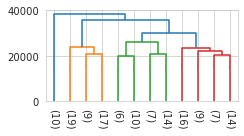

n_clusters = 13

#1f77b4,['(10)']
#ff7f0e,"['(19)', '(9)', '(7)', '(10)']"
#2ca02c,"['(14)', '(6)', '(10)', '(7)']"
#d62728,"['(16)', '(9)', '(7)', '(14)']"


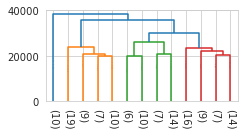

n_clusters = 14

#ff7f0e,"['(4)', '(6)']"
#2ca02c,"['(19)', '(9)', '(7)', '(10)']"
#d62728,"['(7)', '(14)', '(6)', '(10)']"
#9467bd,"['(16)', '(9)', '(7)', '(14)']"


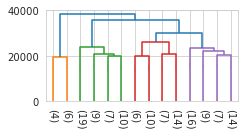

C_1 STR 100% PAL 100% C_2 OLF 100% CTXsp 100% HPF 100% C_3 PERI 93% ECT 92% VISC 71% TEa 46% GU 36% AI 30% AUD 6% C_4 SS 18% VISC 14% TEa 5% AUD 1% C_5 MO 27% SS 8% FRP 3% PL 2% ACA 1% ORB 1% C_6 GU 39% SS 34% MO 24% VISC 13% AI 4% C_7 AUD 44% PTLp 41% VIS 18% TEa 9% SS 9% RSP 3% VISC 1% C_8 VIS 30% TEa 18% RSP 5% AUD 3% ECT 2% PERI 1% C_9 RSP 57% VIS 44% TEa 18% PERI 6% ECT 6% PTLp 3% AUD 2% C_10 AUD 44% PTLp 20% SS 10% VIS 7% TEa 6% C_11 PTLp 36% MO 25% SS 21% ACA 10% RSP 8% VIS 1% C_12 ACA 60% RSP 27% MO 2% C_13 ILA 100% PL 98% ORB 78% FRP 44% ACA 30% MO 16% AI 2% C_14 AI 64% FRP 53% GU 25% ORB 21% MO 6%

STR C_1 100% PAL C_1 100% OLF C_2 100% CTXsp C_2 100% HPF C_2 100% VIS C_9 44% C_8 30% C_7 18% C_10 7% C_11 1% TEa C_3 46% C_8 18% C_9 18% C_7 9% C_10 6% C_4 5% PERI C_3 93% C_9 6% C_8 1% ECT C_3 92% C_9 6% C_8 2% RSP C_9 57% C_12 27% C_11 8% C_8 5% C_7 3% AUD C_10 44% C_7 44% C_3 6% C_8 3% C_9 2% C_4 1% PTLp C_7 41% C_11 36% C_10 20% C_9 3% VISC C_3 71% C_4 14% C_6 13% C_7 1% SS C_6 34% C_11 21% C_4 18% C_10 10% C_7 9% C_5 8% GU C_6 39% C_3 36% C_14 25% ACA C_12 60% C_13 30% C_11 10% C_5 1% AI C_14 64% C_3 30% C_6 4% C_13 2% MO C_5 27% C_11 25% C_6 24% C_13 16% C_14 6% C_12 2% ILA C_13 100% PL C_13 98% C_5 2% ORB C_13 78% C_14 21% C_5 1% FRP C_14 53% C_13 44% C_5 3%

In [12]:
clusters_all = {}

for n_clusters in range(2, 15):
    
    hier_output = get_clust_graph(
        linkage_mat=hier_results['z'],
        c_list=cluster_color_idxs[n_clusters],
        labels=labels,
        num_clusters=n_clusters,
        leaf_font_size=10,
        figsize=(3.5, 2),
    )
    print(f"n_clusters = {n_clusters}")
    display(hier_output['cluster_classes'])
    display(hier_output['fig'])
    print('\n\n')
    
    community = {
        i: translate_labels(leaves, allen['mcc'], forward=False)
        for i, leaves in hier_output['cluster_assigns'].items()
    }
    assert len(community) == n_clusters

    comms3d = np.zeros(allen['template'].shape)
    for cluster_idx, leaves in community.items():
        for lbl in leaves:
            if str(allen['isocortex']['id']) in lbl:
                lr, structure_id, region_id = tuple(map(lambda x: int(x), lbl.split('-')))
                comms3d[parcellation['parcel'] == region_id] = cluster_idx
            else:
                comms3d[roi_masks[lbl]] = cluster_idx
    comms3d = comms3d.astype(int)
    
    # save results
    cluster = Clusters(
        x=comms3d,
        masks=major_masks,
        c_cluster=hier_output['cluster_colors'],
        c_structure=struct_colors,
        threshold=0.0,
    )
    clusters_all[n_clusters] = cluster
    
    with open(pjoin(tmp_dir, f"table-regions_n-{n_clusters}.html"), 'w') as f:
        f.write(cluster.repr_html_regions())
    with open(pjoin(tmp_dir, f"table-clusters_n-{n_clusters}.html"), 'w') as f:
        f.write(cluster.repr_html_clusters())
    
    if n_clusters in [7, 14]:
        print()
        cluster.set_display('clusters')
        display(cluster)
        print()
        cluster.set_display('regions')
        display(cluster)

        print('\n\n\n\n')

In [15]:
cl = clusters_all[7]
cl.set_threshold(10)
cl.set_display('clusters')

cl

C_1 STR 100% PAL 100% OLF 100% CTXsp 100% HPF 100% C_2 PERI 93% ECT 92% VISC 86% TEa 51% GU 36% AI 30% MO 27% SS 26% C_3 GU 39% SS 34% MO 24% VISC 13% C_4 VIS 48% AUD 47% PTLp 41% TEa 26% C_5 RSP 57% VIS 51% AUD 46% TEa 23% PTLp 23% C_6 PTLp 36% MO 25% SS 21% C_7 ILA 100% ORB 99% PL 98% FRP 97% ACA 89% AI 66% RSP 27% GU 25% MO 25%

## Render

In [16]:
for n_clusters in range(2, 15): 
    _ = cluster2html(
        cluster=clusters_all[n_clusters],
        save_name='canberra',
        n_cortex_regions=parcellation['n_cortical_regions'],
        save_dir=extras_dir,
    )

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-2.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-3.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-4.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-5.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-6.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-7.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-8.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-9.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-10.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-11.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-12.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-13.html

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/cluster3d-canberra_parcel-128_n-14.html

## Report properties of a parcellation (TODO)
> use this:
```Python
import pyinspect as pi
```

In [ ]:
    def content(self):
        """
        Prints an overview of the Actors in the scene.
        """

        actors = pi.Report(
            "Scene actors", accent=salmon, dim=orange, color=orange
        )

        for act in self.actors:
            actors.add(
                f"[bold][{amber}]- {act.name}[/bold][{orange_darker}] "
                f"(type: [{orange}]{act.br_class}[/{orange}]) "
                f"(color: [{orange}]{rgb2hex(act.mesh.c())}[/{orange}]) "
                f"(alpha: [{orange}]{act.mesh.alpha()}[/{orange}]) "
            )

        if "win32" != sys.platform:
            actors.print()
        else:
            print(pi.utils.stringify(actors, maxlen=-1))